<a href="https://colab.research.google.com/github/claudio-iturra/colab.research/blob/main/drifters_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ls -l

total 8
drwx------ 6 root root 4096 Nov 28 19:52 drive/
drwxr-xr-x 1 root root 4096 Nov 20 14:30 sample_data/


In [5]:
cd /content/drive/MyDrive/drive/16tb/research_database/drifters/

/content/drive/MyDrive/drive/16tb/research_database/drifters


In [6]:
ls -l

total 17154797
-rw------- 1 root root     3372856 Nov 28 19:27 drifter-centralchile.pkl
-rw------- 1 root root      135478 Aug 27 20:29 drifters.pkl
drwx------ 2 root root        4096 Aug 28 13:52 gdp-get-started-main/
-rw------- 1 root root      902421 Aug 27 16:46 gdp-get-started-main.zip
-rw------- 1 root root 17361507338 Aug 27 17:41 gdp_hourly.nc
-rw------- 1 root root   197215395 Nov 28 17:45 mask.pkl
-rw------- 1 root root     3372856 Nov 28 19:26 my_data.pkl


In [7]:
import xarray as xr
ds = xr.open_dataset('/content/drive/MyDrive/drive/16tb/research_database/drifters/gdp_hourly.nc')

In [8]:
ds

<xarray.Dataset> Size: 17GB
Dimensions:                (traj: 19396, obs: 197214787)
Coordinates:
    ids                    (obs) int64 2GB ...
    time                   (obs) datetime64[ns] 2GB ...
Dimensions without coordinates: traj, obs
Data variables: (12/60)
    ID                     (traj) int64 155kB ...
    rowsize                (traj) int32 78kB ...
    WMO                    (traj) int32 78kB ...
    expno                  (traj) int32 78kB ...
    deploy_date            (traj) datetime64[ns] 155kB ...
    deploy_lat             (traj) float32 78kB ...
    ...                     ...
    err_sst1               (obs) float32 789MB ...
    err_sst2               (obs) float32 789MB ...
    flg_sst                (obs) int8 197MB ...
    flg_sst1               (obs) int8 197MB ...
    flg_sst2               (obs) int8 197MB ...
    drogue_status          (obs) bool 197MB ...
Attributes: (12/16)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           version 2.01. Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2023-09-08T17:05:12.130123
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    summary:           Global Drifter Program hourly data
    doi:               10.25921/x46c-3620

In [10]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter

In [11]:
lon = ds['lon'];
lat = ds['lat'];

In [12]:
df = pd.DataFrame({
    'lon': lon,
    'lat': lat
})

In [13]:
del lon, lat

In [14]:
# 2. Define your bounding box limits
lat_min, lat_max = -39, -33
lon_min, lon_max = -78, -71

# 3. Create the filter mask
# Logic: Lat is between -39 and -33 AND Lon is between -78 and -71
mask = (
    (df['lat'] >= lat_min) & (df['lat'] <= lat_max) &
    (df['lon'] >= lon_min) & (df['lon'] <= lon_max)
)

In [15]:
import pickle
mask.to_pickle("mask.pkl")

In [16]:
ls -l

total 17154797
-rw------- 1 root root     3372856 Nov 28 19:27 drifter-centralchile.pkl
-rw------- 1 root root      135478 Aug 27 20:29 drifters.pkl
drwx------ 2 root root        4096 Aug 28 13:52 gdp-get-started-main/
-rw------- 1 root root      902421 Aug 27 16:46 gdp-get-started-main.zip
-rw------- 1 root root 17361507338 Aug 27 17:41 gdp_hourly.nc
-rw------- 1 root root   197215395 Nov 28 21:44 mask.pkl
-rw------- 1 root root     3372856 Nov 28 19:26 my_data.pkl


In [17]:
# 4. Apply the mask to keep only the data inside the box
df_filtered = df.loc[mask]

In [18]:
idx = df_filtered['lon'].index

In [19]:
import numpy as np

# Example Data: Three consecutive sections (1-3, 10-13, 20-21)
vector = idx

# 1. Calculate the difference between elements
# If diff != 1, it means a sequence has broken
diffs = np.diff(vector)

# 2. Find indices where the difference is NOT 1
# We add 1 because the break happens *after* these indices
break_indices = np.where(diffs != 1)[0] + 1

# 3. Add the absolute start (0) and absolute end (len)
# This gives us all the cut-points
split_indices = np.insert(break_indices, 0, 0)
split_indices = np.append(split_indices, len(vector))

# 4. Zip them together to get (Start, End) pairs
# Note: 'End' is exclusive (standard Python slicing style)
sections = list(zip(split_indices[:-1], split_indices[1:]))

print(f"Split indices: {split_indices}")
print("-" * 30)
for start, end in sections:
    print(f"Index {start} to {end} -> Values: {vector[start:end]}")

Split indices: [     0    913   1759   1978   1981   1984   2657   2662   2671   2708
   2717   2720   2728   2729   4245   4672   5318   5455   6200   7065
   7071   8002   8003   9067   9072   9074   9086  10606  10814  10824
  11036  15210  15211  15590  17631  18487  19864  20174  21785  22140
  22142  22147  22812  22816  23796  27468  27835  28265  28953  30249
  30660  31230  32603  34021  34226  34623  35091  36319  36683  36972
  37999  39337  40234  40390  40454  42424  43031  43042  43056  43626
  43710  43720  43950  45867  46340  46364  46462  46463  46472  46486
  46571  46752  47017  47174  47872  47955  48000  48254  48261  49744
  50673  52418  52441  52859  53695  55426  55733  57583  57813  58052
  58458  58836  59670  59671  60130  60179  60923  62085  62261  62616
  62796  63034  63299  64735  64768  66836  67038  67204  68907  69063
  69070  69081  69130  70474  70941  71526  71904  72686  72969  73668
  77258  79010  79011  79012  79358  79387  79719  79862  8135

In [20]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


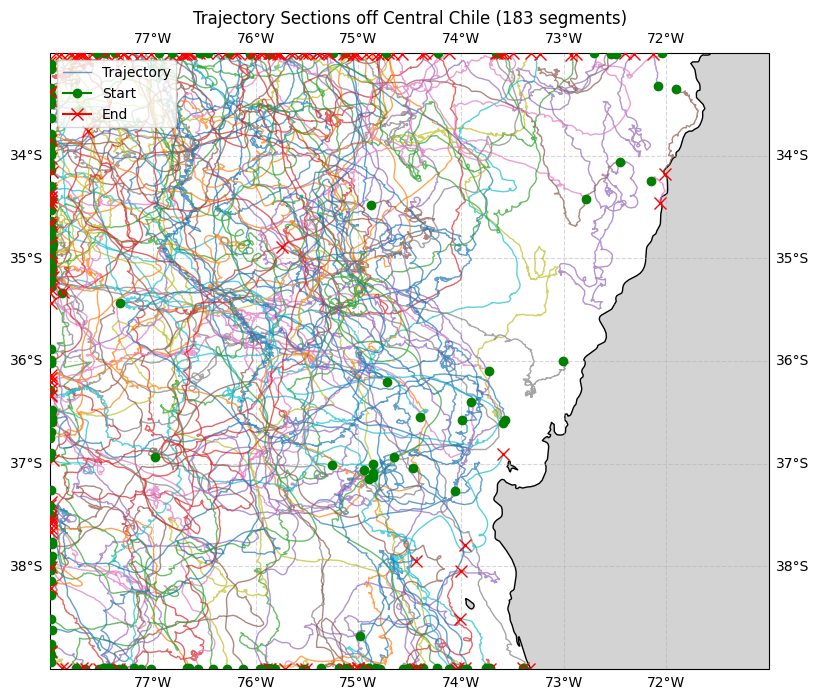

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- 1. Setup the Map (Chilean Coast) ---
fig = plt.figure(figsize=(10, 8))

# We use PlateCarree for the projection because your data is in basic Lat/Lon
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the view to your specific region
# [lon_min, lon_max, lat_min, lat_max]
ax.set_extent([-78, -71, -39, -33], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# --- 2. Plot the Trajectories ---
# Loop through each section found previously
for i in range(len(sections)):
    # Get start and end indices
    start_pos = sections[i][0]
    end_pos = sections[i][1]

    # Extract segment data
    seg_lon = df_filtered['lon'].iloc[start_pos:end_pos]
    seg_lat = df_filtered['lat'].iloc[start_pos:end_pos]

    # Only add labels to the legend for the FIRST iteration (i==0)
    # to avoid having 50 "Start" labels in the legend box.
    lbl_line = 'Trajectory' if i == 0 else None
    lbl_start = 'Start' if i == 0 else None
    lbl_end = 'End' if i == 0 else None

    # Plot Line
    ax.plot(seg_lon, seg_lat, linewidth=1, alpha=0.7,
            transform=ccrs.PlateCarree(), label=lbl_line)

    # Plot Start (Green Dot)
    ax.plot(seg_lon.iloc[0], seg_lat.iloc[0],
            marker='o', color='green', markersize=6, zorder=5,
            transform=ccrs.PlateCarree(), label=lbl_start)

    # Plot End (Red X)
    ax.plot(seg_lon.iloc[-1], seg_lat.iloc[-1],
            marker='x', color='red', markersize=8, zorder=5,
            transform=ccrs.PlateCarree(), label=lbl_end)

# --- 3. Final Touches ---
plt.legend(loc='upper left')
plt.title(f'Trajectory Sections off Central Chile ({len(sections)} segments)')
plt.show()